# Model Comparison & Selection

In this notebook, we compare several candidate classifiers using cross-validation and ROC AUC to identify the best-performing models for our use case. The input data is already preprocessed: 
We have handled missing values and deduplication strategies outside of the modeling pipeline and created a pipeline for simpler preprocessing methods. 

Train/Test Split or 5-fold cross-validation
Models:
- Logistic Regression baseline 
- Additional models: Random Forest, AdaBoost, Gradient Boosting (XGBoost), Neural Network, SVM with RBF Kernel

Pipeline Setup: 5-fold crossvalidation
Use StratifiedKfold to ensure that each fold in the cross-validation process has approximately the same proportion of target classes (recidivist vs. non-recidivist) as the full dataset. 
The is_recid target is imbalanced (around 30–35% positive class).

c:\Users\wastl\modelengineering\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


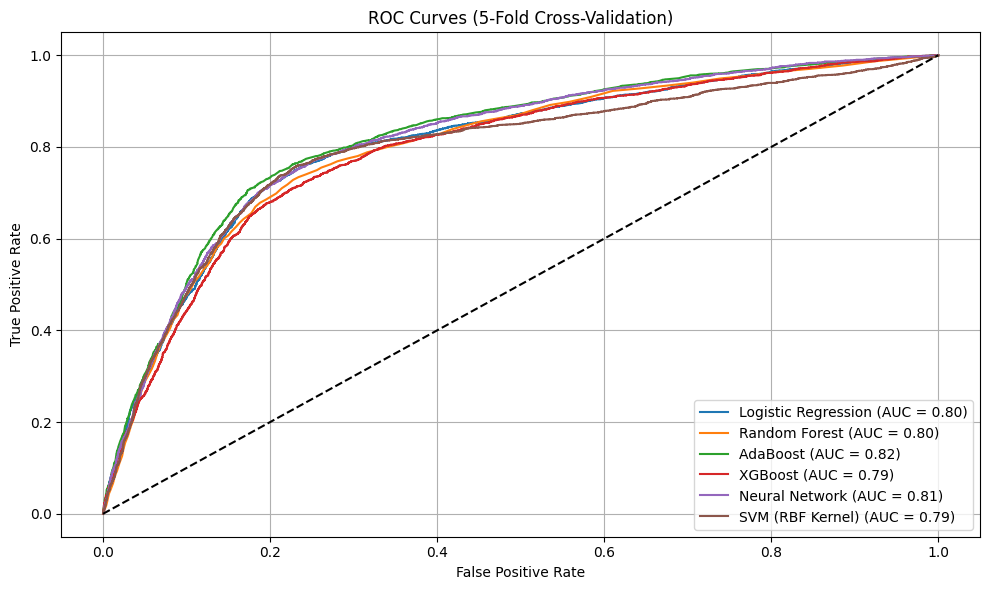

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.770,0.681,0.592,0.633,0.805
1,Random Forest,0.769,0.669,0.616,0.641,0.800
2,AdaBoost,0.784,0.686,0.657,0.671,0.820
3,XGBoost,0.763,0.660,0.607,0.632,0.794
4,Neural Network,0.774,0.680,0.612,0.644,0.814
5,SVM (RBF Kernel),0.769,0.690,0.567,0.623,0.793


In [9]:
# === Model Selection with Pipeline and 7 Selected Features ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load Full Preprocessed Data & Pipeline
df_full = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Separate X and y BEFORE selecting features
X_raw = df_full.drop("is_recid", axis=1)
y = df_full["is_recid"]

# Apply pipeline to full X
X_transformed = pipeline.transform(X_raw)

# Narrow down to the 7 modeling features using their column positions
# Manually map from original column names to indices for modeling
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
column_order = list(X_raw.columns)
selected_indices = [column_order.index(col) for col in selected_features]
X_selected = X_transformed[:, selected_indices]

# Train/Val/Test Split: 70% to train, 30% evaluation (15% validation, 15% test)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, stratify=y_trainval, random_state=42
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define and Train Models 
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = cross_val_predict(model, X_trainval, y_trainval, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_trainval, y_pred), 3),
        "Precision": round(precision_score(y_trainval, y_pred), 3),
        "Recall": round(recall_score(y_trainval, y_pred), 3),
        "F1 Score": round(f1_score(y_trainval, y_pred), 3),
        "AUC": round(roc_auc_score(y_trainval, y_proba), 3)
    })

    fpr, tpr, _ = roc_curve(y_trainval, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_trainval, y_proba):.2f})")

# Plot ROC Curves
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/02_modeling/baseline/model_comparison_roc_curves.png")
plt.show()

# Results Table
results_df = pd.DataFrame(results)
model_order = [
    "Logistic Regression", "Random Forest", "AdaBoost", "XGBoost", "Neural Network", "SVM (RBF Kernel)"
]
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/baseline/model_performance_comparison_5-foldcv.csv", index=False)
results_df


Pipeline Setup: alternatively 80/20 Train/Test Split

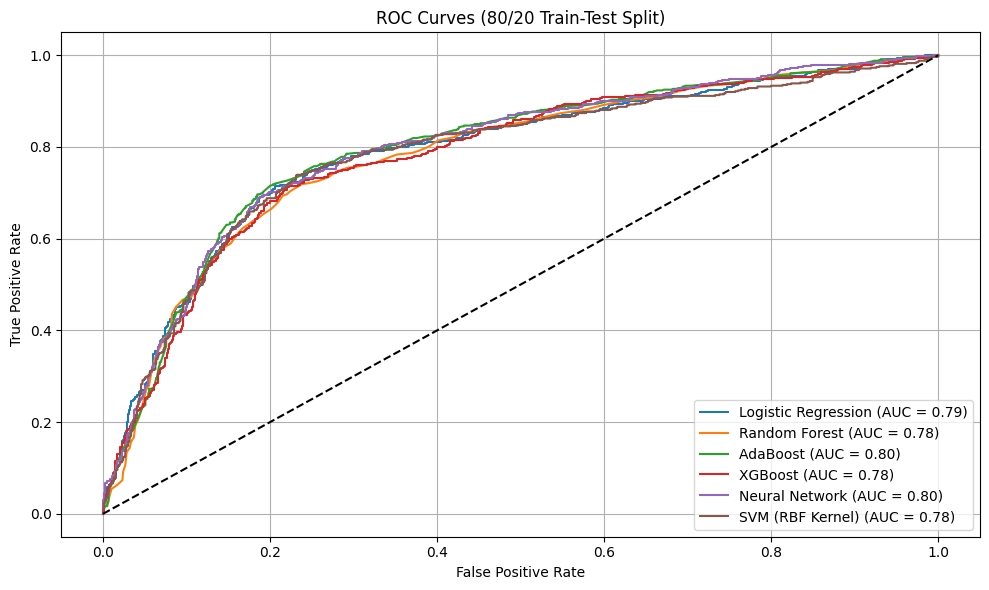

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.767,0.670,0.600,0.633,0.790
1,Random Forest,0.761,0.660,0.589,0.623,0.784
2,AdaBoost,0.776,0.671,0.651,0.661,0.797
3,XGBoost,0.760,0.647,0.622,0.634,0.783
4,Neural Network,0.770,0.671,0.615,0.642,0.796
5,SVM (RBF Kernel),0.769,0.672,0.608,0.639,0.784


In [10]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# === Load Full Preprocessed Data & Pipeline ===
df_full = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# Separate X and y BEFORE selecting features
X_raw = df_full.drop("is_recid", axis=1)
y = df_full["is_recid"]

# Apply pipeline to full X
X_transformed = pipeline.transform(X_raw)

# Narrow down to the 7 modeling features using their column positions
# Manually map from original column names to indices for modeling
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
column_order = list(X_raw.columns)
selected_indices = [column_order.index(col) for col in selected_features]
X_selected = X_transformed[:, selected_indices]

# 85% train/val, 15% test split (for 70% training data, 30% evaluation data of 15% for validation, 15% for test)
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, test_size=0.15, stratify=y, random_state=42)

# 80% train / 20% val within train/val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Train-Test Split)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../reports/02_modeling/baseline/model_comparison_roc_curves_80-20split.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/02_modeling/baseline/model_performance_comparison_80-20ttsplit.csv", index=False)
results_df



Compare 80/20 split vs. 5-fold cross-validation overall performance for next steps to select the two best models: 

In [11]:
# Load both performance result CSVs
df_cv = pd.read_csv("../reports/02_modeling/baseline/model_performance_comparison_5-foldcv.csv")
df_split = pd.read_csv("../reports/02_modeling/baseline/model_performance_comparison_80-20ttsplit.csv")

# Add source column for clarity
df_cv["Setup"] = "5-Fold CV"
df_split["Setup"] = "80/20 Split"

# Combine for comparison
combined_df = pd.concat([df_cv, df_split], ignore_index=True)

# Compare average F1, Recall, Precision, Accuracy across setups
summary = combined_df.groupby("Setup")[["F1 Score", "Recall", "Precision", "Accuracy", "AUC"]].mean().round(3)

summary


,F1 Score,Recall,Precision,Accuracy,AUC
Setup,,,,,
5-Fold CV,0.641,0.608,0.678,0.772,0.804
80/20 Split,0.639,0.614,0.665,0.767,0.789


As performances from the tuned 5-fold cross-validation are better for Precision, F1-Score, Accuracy and AUC, this setup will be selected for selection of the best models. 
Selection logic alternative A priorities: F1 → Precision → Recall → Accuracy
Selection logic alternative B priorities: Precision → F1 → Recall → Accuracy

In [12]:
# Model selection criteria: F1 > Precision > Recall > Accuracy

# Load the model performance results
results_df = pd.read_csv("../reports/02_modeling/baseline/model_performance_comparison_5-foldcv.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_a = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric (higher = better)
ranked_df_a["F1_rank"] = ranked_df_a["F1 Score"].rank(ascending=False, method="min")
ranked_df_a["Precision_rank"] = ranked_df_a["Precision"].rank(ascending=False, method="min")
ranked_df_a["Recall_rank"] = ranked_df_a["Recall"].rank(ascending=False, method="min")
ranked_df_a["Accuracy_rank"] = ranked_df_a["Accuracy"].rank(ascending=False, method="min")

# Weighted score: F1 (highest priority), then Recall, then Precision, then Accuracy
ranked_df_a["Overall_rank_A"] = (
    ranked_df_a["F1_rank"] * 1 +
    ranked_df_a["Precision_rank"] * 2 +
    ranked_df_a["Recall_rank"] * 3 +
    ranked_df_a["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_A = ranked_df_a.sort_values("Overall_rank_A").head(2)

# Combine with baseline
selected_models_A = pd.concat([baseline_model, best_models_A], ignore_index=True)
print("Alternative A - Top Models (F1 > Precision > Recall > Accuracy):")
print(selected_models_A[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])


Alternative A - Top Models (F1 > Precision > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.770      0.681   0.592     0.633  0.805
1             AdaBoost     0.784      0.686   0.657     0.671  0.820
2       Neural Network     0.774      0.680   0.612     0.644  0.814


Selection logic alternative B priorities: Precision → F1 → Recall → Accuracy

In [13]:
# Model selection criteria: (Precision > F1 > Recall > Accuracy)

# Load the model performance results
results_df = pd.read_csv("../reports/02_modeling/baseline/model_performance_comparison_5-foldcv.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_b = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric
ranked_df_b["Precision_rank"] = ranked_df_b["Precision"].rank(ascending=False, method="min")
ranked_df_b["F1_rank"] = ranked_df_b["F1 Score"].rank(ascending=False, method="min")
ranked_df_b["Recall_rank"] = ranked_df_b["Recall"].rank(ascending=False, method="min")
ranked_df_b["Accuracy_rank"] = ranked_df_b["Accuracy"].rank(ascending=False, method="min")

# Weighted score: Recall most important
ranked_df_b["Overall_rank_B"] = (
    ranked_df_b["Precision_rank"] * 1 +
    ranked_df_b["F1_rank"] * 2 +
    ranked_df_b["Recall_rank"] * 3 +
    ranked_df_b["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_B = ranked_df_b.sort_values("Overall_rank_B").head(2)

# Combine with baseline
selected_models_B = pd.concat([baseline_model, best_models_B], ignore_index=True)
print("Alternative B - Top Models (Precision > F1 > Recall > Accuracy):")
print(selected_models_B[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])

Alternative B - Top Models (Precision > F1 > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.770      0.681   0.592     0.633  0.805
1             AdaBoost     0.784      0.686   0.657     0.671  0.820
2       Neural Network     0.774      0.680   0.612     0.644  0.814


Evaluate all untuned models regarding metrics and learning curves. 

Training: Logistic Regression


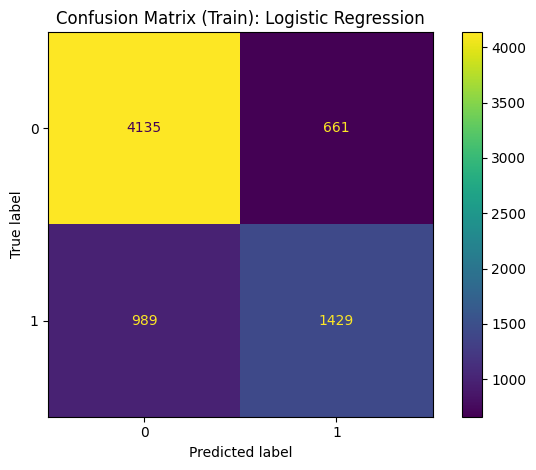

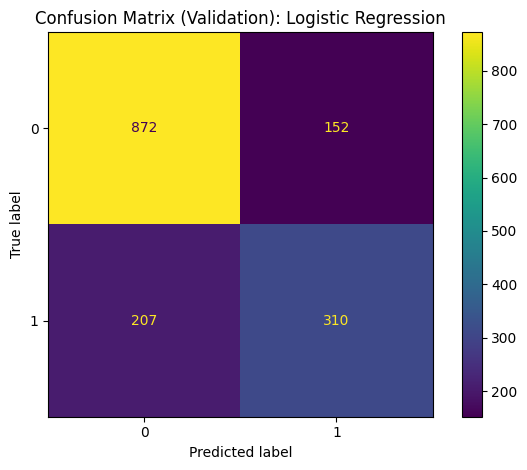

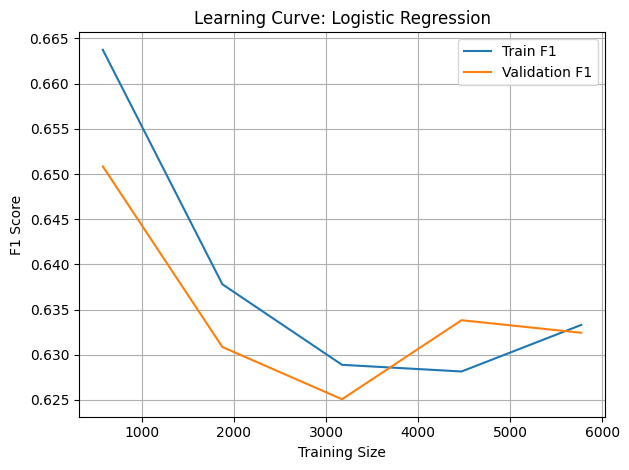

Training: AdaBoost


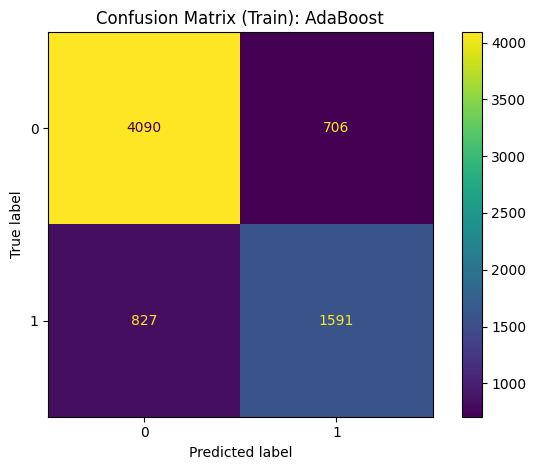

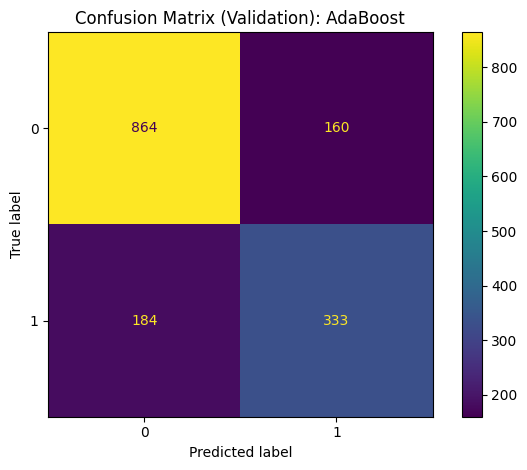

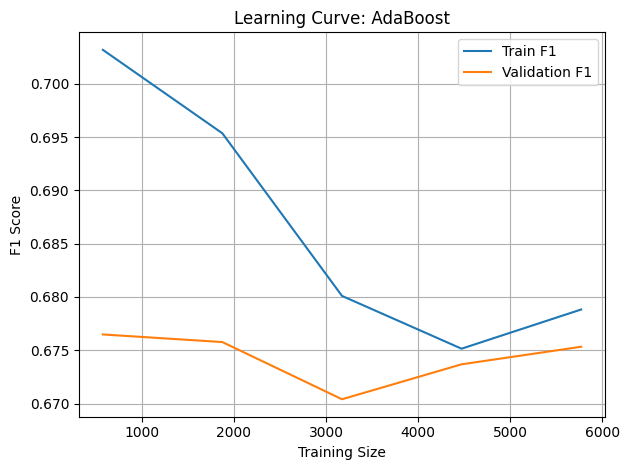

Training: Neural Network


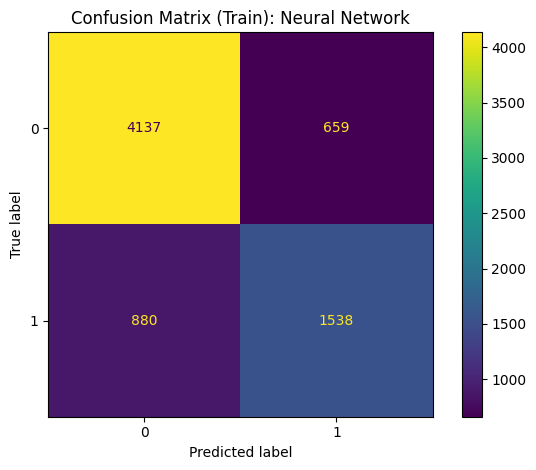

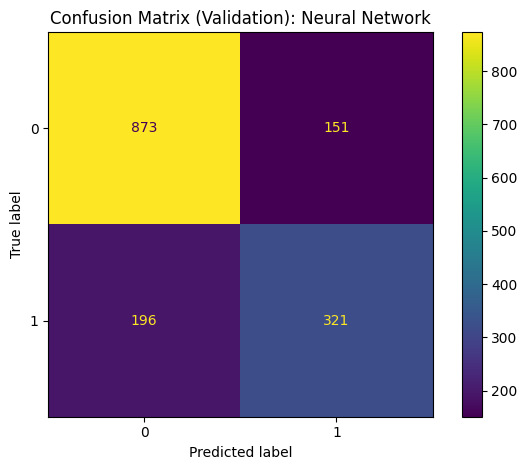

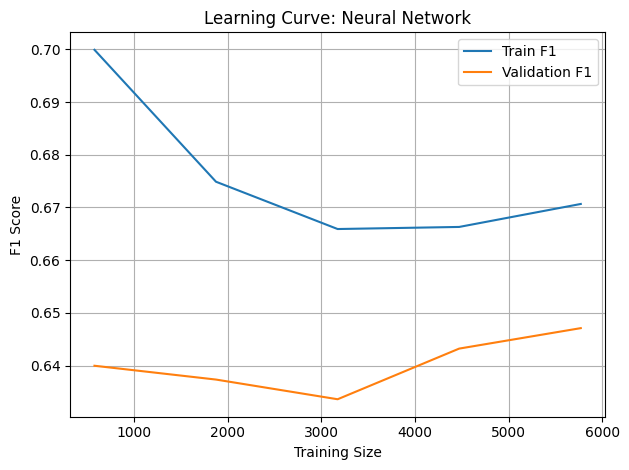

,Set,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,Logistic Regression,0.771,0.684,0.591,0.634,0.807
1,Validation,Logistic Regression,0.767,0.671,0.600,0.633,0.800
2,Train,AdaBoost,0.787,0.693,0.658,0.675,0.832
3,Validation,AdaBoost,0.777,0.675,0.644,0.659,0.804
4,Train,Neural Network,0.787,0.700,0.636,0.667,0.836
5,Validation,Neural Network,0.775,0.680,0.621,0.649,0.801


In [14]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os

from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# === Load data and preprocessing pipeline ===
df_full = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

# === Prepare features and target ===
X_raw = df_full.drop("is_recid", axis=1)
y = df_full["is_recid"]
X_transformed = pipeline.transform(X_raw)

# === Select only 7 modeling features ===
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
column_order = list(X_raw.columns)
selected_indices = [column_order.index(col) for col in selected_features]
X_selected = X_transformed[:, selected_indices]

# === Train/Val/Test Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, stratify=y_trainval, random_state=42
)

# === Cross-validation for learning curves only ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
top_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    # "Random Forest": Pipeline([
    #     ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    # ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    # "XGBoost": Pipeline([
    #     ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    # ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    # "SVM (RBF Kernel)": Pipeline([
    #     ("scaler", StandardScaler()),
    #     ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    # ])
}

# === Output prep ===
os.makedirs("../reports/02_modeling/baseline", exist_ok=True)
os.makedirs("../models/baseline", exist_ok=True)
metrics = []

# === Loop over models ===
for name, model in top_models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)

    # Save baseline model
    joblib.dump(model, f"../models/baseline/{name.lower().replace(' ', '_')}_baseline.pkl")

    # Evaluate on Train and Validation sets
    for split_name, X_split, y_split in [
        ("Train", X_train, y_train),
        ("Validation", X_val, y_val),
    ]:
        y_proba = model.predict_proba(X_split)[:, 1]
        y_pred = model.predict(X_split)

        acc = accuracy_score(y_split, y_pred)
        precision = precision_score(y_split, y_pred)
        recall = recall_score(y_split, y_pred)
        f1 = f1_score(y_split, y_pred)
        auc = roc_auc_score(y_split, y_proba)

        metrics.append({
            "Set": split_name, "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3)
        })

        # Confusion Matrix
        cm = confusion_matrix(y_split, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix ({split_name}): {name}")
        plt.tight_layout()
        plt.savefig(f"../reports/02_modeling/baseline/confmatrix_{split_name.lower()}_{name.lower().replace(' ', '_')}.png")
        plt.show()

        # Classification Report
        with open(f"../reports/02_modeling/baseline/classification_report_{split_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
            f.write(classification_report(y_split, y_pred))

    # Learning Curve (on training set only)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring="f1",
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation F1")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/02_modeling/baseline/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

# === Save metrics summary ===
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../reports/02_modeling/baseline/model_selection_metrics_summary.csv", index=False)
metrics_df




Feature Importance Tests per model: 

Explaining model: AdaBoost


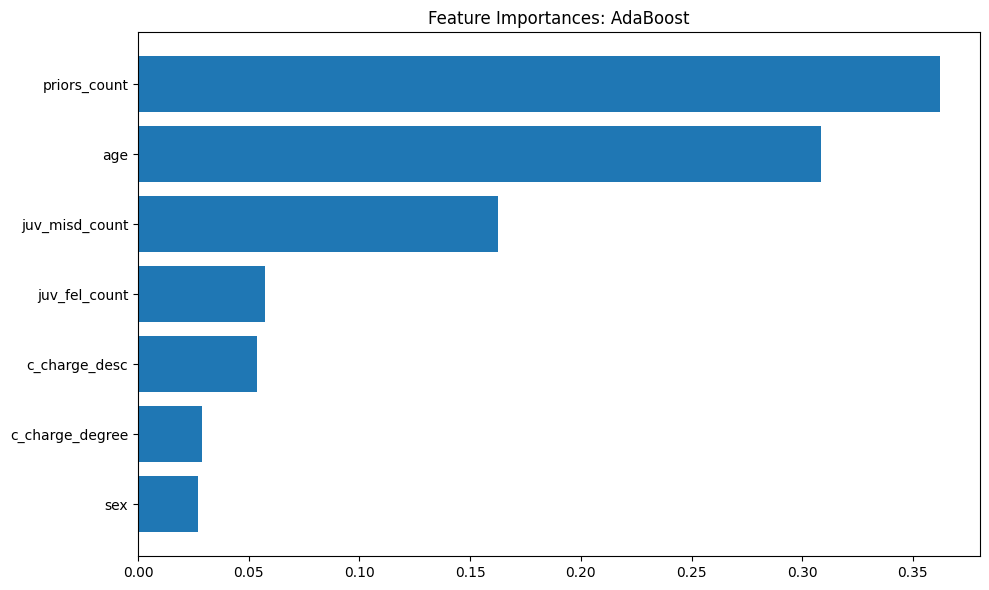

Explaining model: Logistic Regression


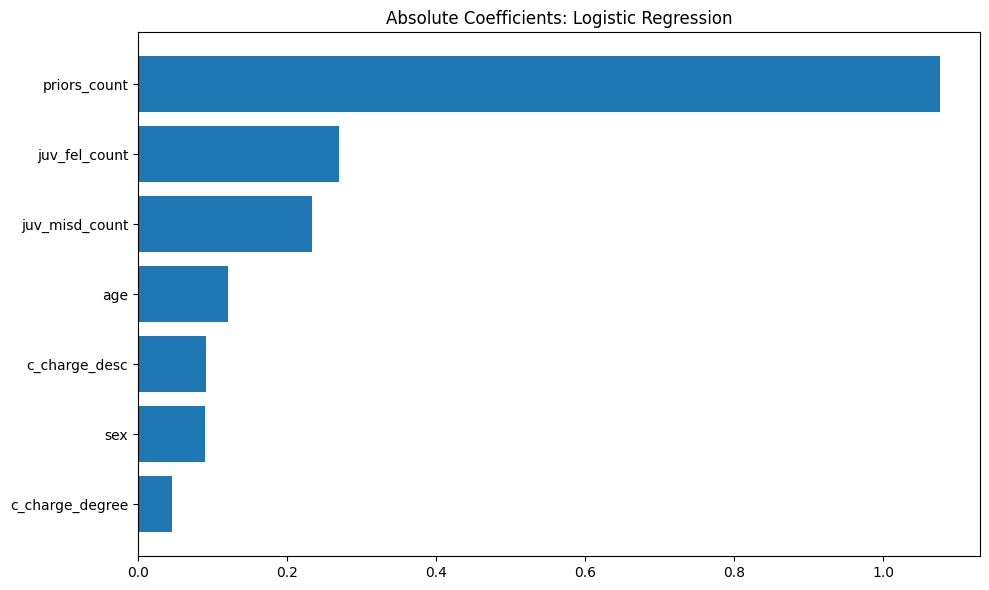

Explaining model: Neural Network


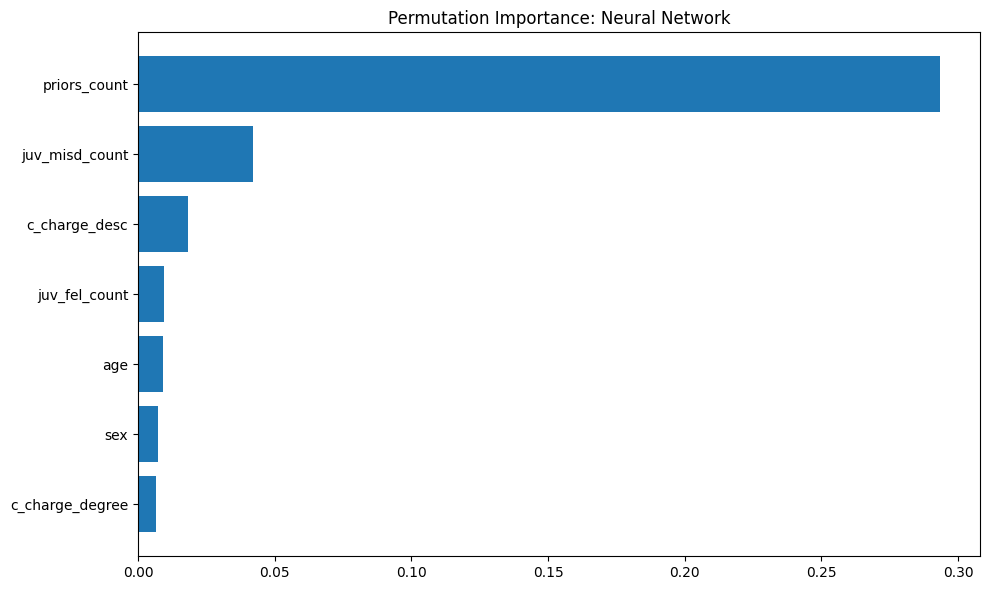

In [15]:
from sklearn.inspection import permutation_importance

# Ensure consistent feature names
feature_names = selected_features

# Loop through selected models
for name in ["AdaBoost", "Logistic Regression", "Neural Network"]:
    print(f"Explaining model: {name}")
    model_path = f"../models/baseline/{name.lower().replace(' ', '_')}_baseline.pkl"
    model = joblib.load(model_path)
    clf = model.named_steps["clf"]

    if hasattr(clf, "feature_importances_"):
        # AdaBoost / Tree-based methods
        importances = clf.feature_importances_
        title = "Feature Importances"
    elif hasattr(clf, "coef_"):
        # Logistic Regression
        importances = np.abs(clf.coef_[0])
        title = "Absolute Coefficients"
    else:
        # Permutation importance for Neural Network or others
        result = permutation_importance(
            model, X_trainval, y_trainval, n_repeats=10, random_state=42, scoring="f1"
        )
        importances = result.importances_mean
        title = "Permutation Importance"

    # Prepare DataFrame
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.title(f"{title}: {name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"../reports/02_modeling/baseline/feature_importance_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # Export
    importance_df.to_csv(f"../reports/02_modeling/baseline/feature_importances_{name.lower().replace(' ', '_')}.csv", index=False)
